# Neural style transfer

The last few weekends, I've been experimenting with neural style transfer. 
Style transfer combines two images to create a new image with similar content as one image but using the style from the other image.

For example, using the technique in the paper [A Neural Algorithm of Artistic Style](https://arxiv.org/abs/1508.06576) and code from [the example implementation from Keras](https://github.com/keras-team/keras/blob/master/examples/neural_style_transfer.py), I can produce stylized images of Mt. Hood.

| [Original](https://en.wikipedia.org/wiki/Mount_Hood#/media/File:Mount_Hood_reflected_in_Mirror_Lake,_Oregon.jpg) | [Tsunami](https://en.wikipedia.org/wiki/The_Great_Wave_off_Kanagawa#/media/File:Tsunami_by_hokusai_19th_century.jpg) | [The Scream](https://en.wikipedia.org/wiki/The_Scream#/media/File:The_Scream_by_Edvard_Munch,_1893_-_Nasjonalgalleriet.png) | [Primordal Chaos](https://en.wikipedia.org/wiki/Hilma_af_Klint#/media/File:Hilma_af_Klint,_1906-07,_Primordial_Chaos_-_No_16.jpg) |
|-|-|-|-|
| ![](images/2019-03-17-mt-hood.jpg) | ![](images/2019-03-17-tsunami.png) | ![](images/2019-03-17-scream.png) | ![](images/2019-03-17-primordial-chaos.png) |
| ![](images/2019-03-17-mt-hood.jpg) | ![](images/2019-03-17-orig-tsunami.jpg) | ![](images/2019-03-17-orig-scream.png) | ![](images/2019-03-17-orig-primordial-chaos.jpg) |


This post shows what the technique is doing and includes an implementation heavily based on [Keras's example implementation](https://github.com/keras-team/keras/blob/master/examples/neural_style_transfer.py).

After some nice examples of how it should work in theory, I also note some learnings and weird results.

## Source images

This technique combines two images: a content image and a style image.

(As usual, the full notebook is on [github](https://github.com/jessstringham/notebooks/blob/master/2019-03-17-style-transfer.ipynb).)

In [1]:
# hiding this code block in blog post

import keras.backend as K
from keras.models import Model
from keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import requests

SAVE = True
def maybe_save_plot(filename):
    if SAVE:
        plt.tight_layout()
        plt.savefig('images/' + filename, bbox_inches="tight")

def hide_ticks(plot):
    plot.axes.get_xaxis().set_visible(False)
    plot.axes.get_yaxis().set_visible(False) 

TARGET_IMAGE_WIDTH = 512

# Where to save the images
CONTENT_PATH = 'data/content.jpg'
STYLE_PATH = 'data/style.jpg'

def download_image(image_url, destination_path):
    with open(destination_path, 'wb') as f:
        f.write(requests.get(image_url).content)
        
def scale_image_height(image_path, target_width):
    w, h = image.load_img(image_path).size
    return int(h * target_width / w)

# Download content and style images. Use the content image to set up the target image size.

content_img_url = 'https://upload.wikimedia.org/wikipedia/commons/e/ef/Mount_Hood_reflected_in_Mirror_Lake%2C_Oregon.jpg'

download_image(content_img_url, CONTENT_PATH)
target_image_height = scale_image_height(CONTENT_PATH, TARGET_IMAGE_WIDTH)

target_image_size = (target_image_height, TARGET_IMAGE_WIDTH, 3)

style_img_url = 'https://upload.wikimedia.org/wikipedia/commons/9/93/Van_Gogh_-_Acker_mit_pfl%C3%BCgenden_Bauern.jpeg'
download_image(style_img_url, STYLE_PATH)

Using TensorFlow backend.


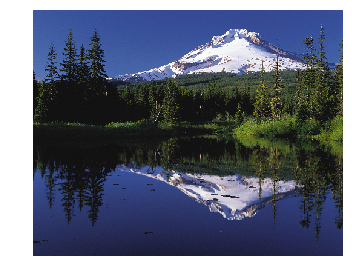

In [2]:
content_img = image.load_img(CONTENT_PATH, target_size=target_image_size[:-1])
plt.imshow(image.img_to_array(content_img).astype('int64'))
plt.axis('off')
maybe_save_plot('2019-03-17-orig-content')

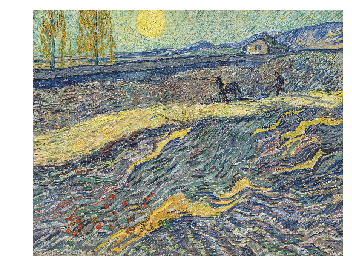

In [3]:
style_img = image.load_img(STYLE_PATH, target_size=target_image_size[:-1])
plt.imshow(image.img_to_array(style_img).astype('int64'))
plt.axis('off')
maybe_save_plot('2019-03-17-orig-style')

### Start with a pretrained network

Often in deep learning, you need to train a network on a lot of data to get good results.
However, this neural style transfer technique starts with a network that has already been trained on huge amounts of data. 

I used the [VGG19](https://keras.io/applications/#vgg19) packaged with Keras which has been trained on the gigantic ImageNet dataset.
VGG19 on ImageNet was trained to classify what was in images (e.g. tell that a picture is of a "car").

In [4]:
from keras.applications import vgg19

regular_vgg = vgg19.VGG19(weights='imagenet', include_top=False)

regular_vgg.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
bloc

    _________________________________________________________________
    Layer (type)                 Output Shape              Param #   
    =================================================================
    input_1 (InputLayer)         (None, None, None, 3)     0         
    _________________________________________________________________
    block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
    _________________________________________________________________
    block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
    _________________________________________________________________
    block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
    _________________________________________________________________
    block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
    _________________________________________________________________
    block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
    _________________________________________________________________
    block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
    _________________________________________________________________
    block3_conv1 (Conv2D)        (None, None, None, 256)   295168    
    _________________________________________________________________
    block3_conv2 (Conv2D)        (None, None, None, 256)   590080    
    _________________________________________________________________
    block3_conv3 (Conv2D)        (None, None, None, 256)   590080    
    _________________________________________________________________
    block3_conv4 (Conv2D)        (None, None, None, 256)   590080    
    _________________________________________________________________
    block3_pool (MaxPooling2D)   (None, None, None, 256)   0         
    _________________________________________________________________
    block4_conv1 (Conv2D)        (None, None, None, 512)   1180160   
    _________________________________________________________________
    block4_conv2 (Conv2D)        (None, None, None, 512)   2359808   
    _________________________________________________________________
    block4_conv3 (Conv2D)        (None, None, None, 512)   2359808   
    _________________________________________________________________
    block4_conv4 (Conv2D)        (None, None, None, 512)   2359808   
    _________________________________________________________________
    block4_pool (MaxPooling2D)   (None, None, None, 512)   0         
    _________________________________________________________________
    block5_conv1 (Conv2D)        (None, None, None, 512)   2359808   
    _________________________________________________________________
    block5_conv2 (Conv2D)        (None, None, None, 512)   2359808   
    _________________________________________________________________
    block5_conv3 (Conv2D)        (None, None, None, 512)   2359808   
    _________________________________________________________________
    block5_conv4 (Conv2D)        (None, None, None, 512)   2359808   
    _________________________________________________________________
    block5_pool (MaxPooling2D)   (None, None, None, 512)   0         
    =================================================================
    Total params: 20,024,384
    Trainable params: 20,024,384
    Non-trainable params: 0
    _________________________________________________________________

In [5]:
# hiding this code block in blog post

# These are helper functions to preprocess and remove the preprocessing 
# of images before passing them through VGG.
# They are both copied from the Keras example!
def preprocess(img):
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

def deprocess(x):
    x = np.copy(x)
    x = x.reshape(target_image_size)
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

## VGG19 examples

A hand-wavy explanation of why this is useful is that the trained VGG19 network has already learned a good way to represent images. For example, to identify "a car", maybe the network learned that a car has shiny surfaces (and superficial features like "shiny" are in theory detected by lower-valued blocks of the network) and that a car has four wheels and is usually on a road (and more abstract features, such as neurons for "wheel" and ones for "road", are in higher-valued blocks of the network). 
The neural style transfer technique I'm using works by trying to draw the abstract features from the content image, such as "wheels" and "road", while matching the superficial features from the style image, such as "shiny" or "lots of blue brush strokes".

To get an idea of those "wheel" neurons, we can look at what VGG19 produces at different layers.

In [6]:
def create_vgg_layer_outputs(input_tensor):
    vgg = vgg19.VGG19(input_tensor=input_tensor, weights='imagenet', include_top=False)

    # order all of the outputs and their names
    vgg_layer_outputs = [
        (layer.name, layer.output)
        for layer in vgg.layers
    ]
    layer_names, layer_outputs = zip(*vgg_layer_outputs)
    
    # evaluate the outputs all at once
    output_values = K.function([], layer_outputs)([])
    
    # and return the labeled output values
    return dict(zip(layer_names, output_values))

### Content image convolutional outputs

Let's look inside and see how the network represents the content image. I'll go to various layers and print out what a few features look like.

I'm only printing 3 filters from each layer (for example, `block5_conv1` has 512 filters), so this is just a peak into how the network is representing the image.

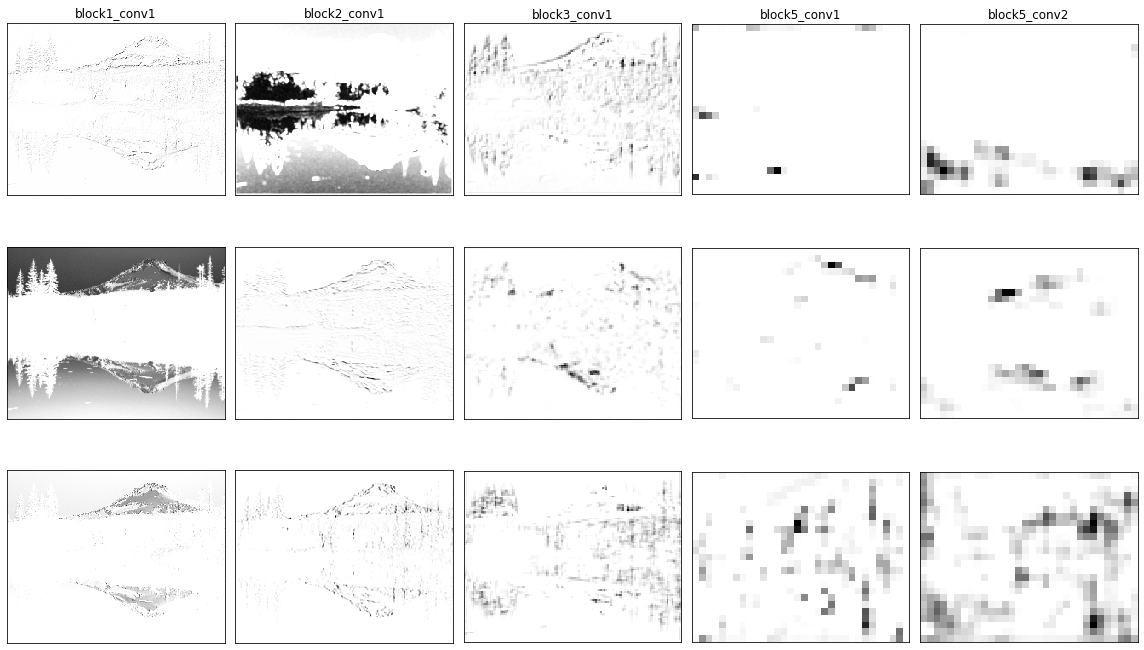

In [11]:
content_tensor = K.variable(preprocess(content_img))
vgg_layer_outputs = create_vgg_layer_outputs(content_tensor)

layer_names = [
    'block1_conv1',
    'block2_conv1',
    'block3_conv1',
    'block5_conv1',
    'block5_conv2',
]

fig, axs = plt.subplots(3, 5, figsize=(16, 10))

for col_i, layer_name in enumerate(layer_names):
    for i, ax in enumerate(axs[:, col_i]):
        ax.imshow(vgg_layer_outputs[layer_name][0, :, :, i], cmap='Greys')
        hide_ticks(ax)
        
    axs[0, col_i].set_title(layer_name)

maybe_save_plot('2019-03-17-content-convs')    

### Style image convolutional outputs

For fun, I can do the same on the style image.

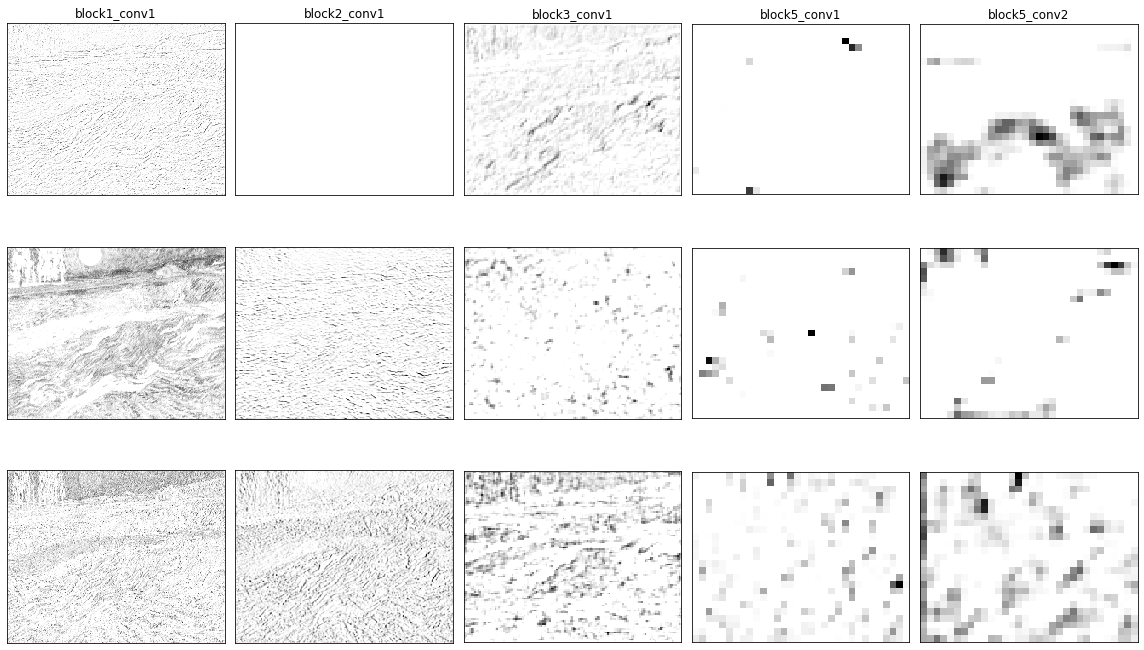

In [8]:
style_tensor = K.variable(preprocess(style_img))
vgg_layer_outputs = create_vgg_layer_outputs(style_tensor)

fig, axs = plt.subplots(3, 5, figsize=(16, 10))

for col_i, layer_name in enumerate(layer_names):
    for i, ax in enumerate(axs[:, col_i]):
        ax.imshow(vgg_layer_outputs[layer_name][0, :, :, i], cmap='Greys')
        hide_ticks(ax)
        
    axs[0, col_i].set_title(layer_name)

maybe_save_plot('2019-03-17-style-convs')

## Setting up a loss function

In order to make an image that combines the images, I'll have the network nudge the pixel values of a third image, which I call the "variable image." To guide how to nudge the image, [the paper](https://arxiv.org/abs/1508.06576) describes a loss function based on a "content loss" and a "style loss". The [Keras code](https://github.com/keras-team/keras/blob/master/examples/neural_style_transfer.py) adds a "variational loss."

#### Content loss

The content loss tries to get a deep layer, such as `block5_conv2`, of the content image to match the variable image. Since the deep layers should represent larger, abstract items ("a tower", "some grass", "the sky"), the content loss should encourage the resulting image to share the content of the image.

#### Style loss

The style loss tries to get shallower layers, such as `block1_conv1`, from the style image to match the variable image. 
Instead of matching the layers values directly, the style loss is based on the Grams matrix of vectorized features layer. That means that all information about the location is squashed.

(Aside: [I wrote a little another use of Grams matrix here](2018/05/20/Multidimensional-Scaling.html)).

#### Variational loss

The variational loss penalizes the variable image if pixels next to each other are very different. This smooths the resulting image.

### Defining which layers to use

Typically, "shallow layers" should have a non-zero style weight, and "deeper layers" should have a non-zero content weight. I set my implementation up so I could configure which layers to use and how much to weight each layer.

In [13]:
from collections import namedtuple

LayerWeights = namedtuple('LayerWeights', ['layer_name', 'style_weight', 'content_weight'])

layer_weights = [
    LayerWeights('block1_conv1', style_weight=1, content_weight=0.0),
    LayerWeights('block2_conv1', style_weight=1, content_weight=0.0),    
    LayerWeights('block3_conv1', style_weight=1, content_weight=0.0),    
    LayerWeights('block4_conv1', style_weight=1, content_weight=0.0),        
    LayerWeights('block5_conv1', style_weight=1, content_weight=0.0),            
    LayerWeights('block5_conv2', style_weight=0.0, content_weight=1e2),
]

Now I'll define a `loss_from_layer_weights` based on the provided `layer_weights`.

In [14]:
# Borrowing a few more functions from the Keras example
def sum_squared(content, variable):
    return K.sum(K.square(content - variable))

# This returns a matrix with the size [3, FEATURE_SIZE, FEATURE_SIZE]
def gram_matrix(x):
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram

In [15]:
def loss_from_layer_weights(layer_weights, vgg_layer_outputs, variable_tensor):
    loss = K.variable(0.0)

    for layer in layer_weights:
        # Separate the three images again
        content_layer_out = vgg_layer_outputs[layer.layer_name][0]
        style_layer_out = vgg_layer_outputs[layer.layer_name][1]
        variable_layer_out = vgg_layer_outputs[layer.layer_name][2]
        
        # All images should be the same time
        width, height, filters = content_layer_out.shape
        
        # Add the content weights
        loss += layer.content_weight * sum_squared(content_layer_out, variable_layer_out)
        
        # Add the style weights
        # The paper divides the style loss by 4 * M**2 * N**2.
        style_denominator = 4 * int(width * height * filters) ** 2
        loss += layer.style_weight * sum_squared(
            gram_matrix(style_layer_out),
            gram_matrix(variable_layer_out)
        ) / style_denominator
        
    # Add variation loss to make sure pixels next to each other are similar
    raw_variation_loss = (
        K.square(variable_tensor[:, :-1, :-1] - variable_tensor[:, 1:, :-1]) 
        + K.square(variable_tensor[:, :-1, :-1] - variable_tensor[:, :-1, 1:])
    )
    total_variation_loss = K.sum(K.pow(raw_variation_loss, 1.25))
    loss += total_variation_loss
    
    return loss   

In [16]:
def neural_style_loss(
    content_tensor,
    style_tensor,
    variable_tensor, 
    layer_weights):

    input_tensor = K.concatenate([
        content_tensor,
        style_tensor,
        variable_tensor,
    ], axis=0)
    
    # Get a VGG model
    vgg = vgg19.VGG19(input_tensor=input_tensor, weights='imagenet', include_top=False)

    # Name all of VGG's layers
    vgg_layer_outputs = {
        layer.name: layer.output
        for layer in vgg.layers
    }
    
    # Build the loss function
    loss = loss_from_layer_weights(
        layer_weights, 
        vgg_layer_outputs,
        variable_tensor,
    )
    
    # Return a function that, given the variable tensor, will return the loss and gradients.
    grads = K.gradients(loss, variable_tensor)
    return K.function([variable_tensor], [loss] + grads)

f_loss_and_grads = neural_style_loss(
    content_tensor,
    style_tensor,
    variable_tensor, 
    layer_weights
)

### Initializing the image

My favorite results happened when I initialized with random noise.

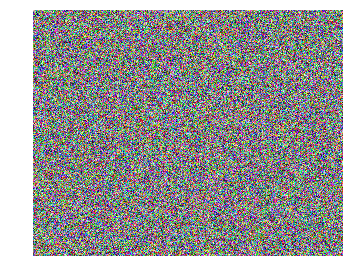

In [12]:
# Set up the tensor we'll use later
variable_tensor = K.placeholder((1, *target_image_size))

# Set up the initial value to pass into that tensor
result_image = preprocess(np.random.rand(*preprocess(content_img).shape)[0] * 256)
plt.imshow(deprocess(result_image))
plt.axis('off')
maybe_save_plot('2019-03-17-initial-image')

### Fitting the model

With `f_loss_and_grads`, I have a function that can tell me how far the variable image is from the ideal image. Now I need a way to update the variable image to make it closer to ideal!

There are a few choices of optimizers. The Keras example uses `scipy`'s `fmin_l_bfgs_b`. It needs a function that returns the loss function's value for an image, and a function that returns and the loss function's gradients for an image.

(I also used BFGS in my [logistic regression post](/2018/05/22/logistic-regression.html)!)

In [17]:
# Again, borrowing from the Keras example. `f_loss_and_grads` takes a few seconds to run. 
# Instead of calling it twice, the Keras example stores the results.

class GradientAndLoss():
    def __init__(self):
        self._grad = None
        self._loss = None

    def loss(self, flat_image):
        assert self._grad is None
        self._loss, self._grad = f_loss_and_grads([
            flat_image.reshape((1, *target_image_size))
        ])
        return self._loss

    def grad(self, flat_image):
        assert self._grad is not None
        grad = np.copy(self._grad)
        self._loss = None
        self._grad = None
        return grad.flatten().astype('float64')

gradient_and_loss = GradientAndLoss()

Now I run the following code block on a GPU a few times until I get a good image.

In [ ]:
from scipy.optimize import fmin_l_bfgs_b

for _ in range(10):
    result_image, min_val, info = fmin_l_bfgs_b(
        gradient_and_loss.loss, 
        result_image.flatten(),
        gradient_and_loss.grad, 
        maxfun=20)

    plt.imshow(deprocess(result_image))
    plt.show()
    plt.axis('off')

<img width=300px src="images/2019-03-17-result.png">

## Results

Now that I have a better image, I can compare it to the original.
I should see that the content layers match the content. I might notice the style image being similar.

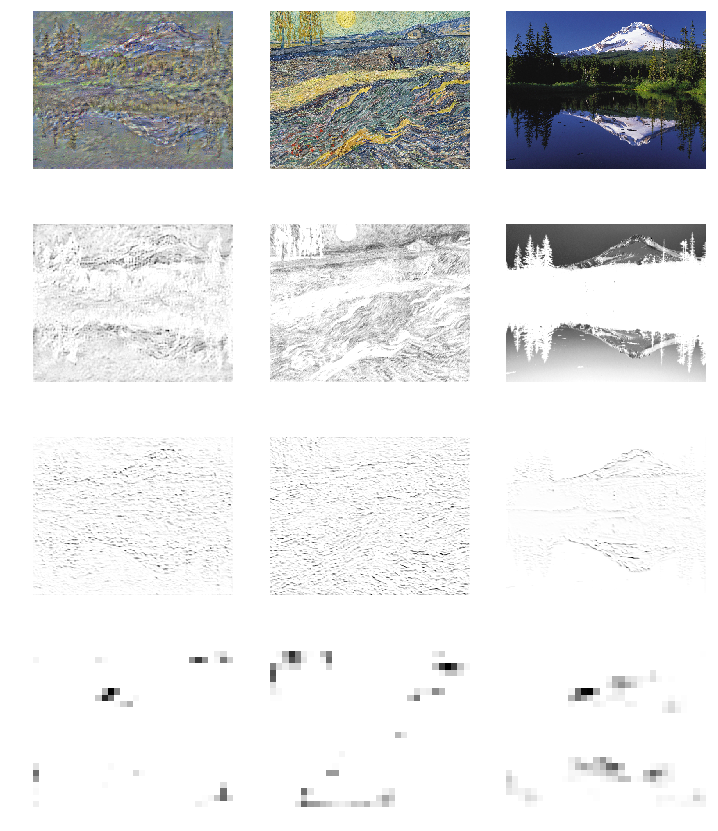

In [25]:
result_image = image.load_img("images/2019-03-17-result.png", target_size=target_image_size[:-1])
finished_variable_tensor = K.variable(preprocess(result_image))
var_output_dict = create_vgg_layer_outputs(finished_variable_tensor)
style_output_dict = create_vgg_layer_outputs(style_tensor)
content_output_dict = create_vgg_layer_outputs(content_tensor)


FEATURE_LAYER = 1

fig, axs = plt.subplots(4, 3, figsize=(10, 12))

axs[0][0].imshow(result_image)
axs[0][0].axis('off')

axs[0][1].imshow(style_img)
axs[0][1].axis('off')    

axs[0][2].imshow(content_img)
axs[0][2].axis('off')  


for i, layer_name in enumerate(['block1_conv1', 'block2_conv1', 'block5_conv2']):
    i = i + 1
    axs[i][0].imshow(var_output_dict[layer_name][0, :, :, FEATURE_LAYER], cmap='Greys')
    axs[i][0].axis('off')

    axs[i][1].imshow(style_output_dict[layer_name][0, :, :, FEATURE_LAYER], cmap='Greys')
    axs[i][1].axis('off')    
    
    axs[i][2].imshow(content_output_dict[layer_name][0, :, :, FEATURE_LAYER], cmap='Greys')
    axs[i][2].axis('off')  
    
maybe_save_plot('2019-03-17-three-images')    

## Etc

This project was neat. Besides making images I think are cool, it's an example of a deep learning project that doesn't need a lot of custom data: I just need the style image and content image and the VGG19 network weights. 
 
### Failed images

In this post, I showed some cool images, but many of the combinations I tried resulted in muddy images that didn't look very good.
I think there's a reason certain images (Starry Night, The Scream, Tsunami, Picasso) are so common in Neural Style Transfer posts!
There are a lot of choices in parameters, and the scaling of the image influences the layer detection. It's hard to tell if combinations would turn out better if I had tweaked the parameters right, or if the method wouldn't work. For example, in the example below, some parameters weren't weighted right.

<img width=300px src="images/2019-03-17-ghost-church.png">

<small>Oh no, the Uppsala cathedral is a ghost. [style](https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/580px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg), [content](https://sv.wikipedia.org/wiki/Uppsala_domkyrka#/media/File:Uppsala_Cathedral_in_February.jpg)</small>


Also some of my favorite results didn't really copy the style, but just made a cool looking result (Primordial Chaos, and the Sutro Tower image below).

<img width=180px src="images/2019-03-17-sutro.png">

<small>Sutro Tower. [style](https://en.wikipedia.org/wiki/Brussels_International_Exposition_(1897)#/media/File:International_Exhibition_Brussels_par_Privat-Livemont.jpg), [content](https://en.wikipedia.org/wiki/Sutro_Tower#/media/File:Sutro_Tower_from_Grandview.jpg)</small>

### Code

I really like being able to implement methods from scratch.
So I feel a little weird that this post is mostly the [provided Keras example](https://github.com/keras-team/keras/blob/fcf2ed7831185a282895dda193217c2a97e1e41d/examples/neural_style_transfer.py), with different configuration (I like my `namedtuples`), and some code deleted or moved around.

I started this post by trying to implement Neural Style Transfer in Keras using the paper from scratch. My method was slow and images weren't turning out very good (looking back, that might be in part because of the technique, and not running on a GPU.) Also a few things in the implementation felt awkward: for example, I was feeding in the same image in each epoch.


### GPUs

My laptop was pretty slow at generating the images, so I used a GPU in [Colaboratory](https://colab.research.google.com).




### Other posts

There are a few other folks who have looked into ways to make this work better.

 - One more time, the [provided Keras example](https://github.com/keras-team/keras/blob/fcf2ed7831185a282895dda193217c2a97e1e41d/examples/neural_style_transfer.py)
 